In [ ]:
import pandas as pd
from glob import glob
import os
import re
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'seaborn'

First, we want to clean up the hundreds of .txt files in the name subdirectory by combining them all, in order, into one big .csv file.

In [2]:
# naming convention of the name txt files for each year of birth
pattern = os.path.join('names', 'yob*.txt')
files = sorted(glob(pattern))

if not files:
    raise FileNotFoundError(f"No files found with pattern: {pattern}")

dfs = []
for path in files:
    # extract yob from file name
    fname = os.path.basename(path)
    try:
        year = int(fname.replace('yob', '').replace('.txt', ''))
    except ValueError:
        # skip files that don't match the expected pattern
        print(f"Skipping unexpected filename: {fname}")
        continue

    # read file
    df = pd.read_csv(path, header=None, names=['name', 'sex', 'count'], dtype={'name': str, 'sex': str, 'count': int})
    # create year column using yob from file names
    df['year'] = year
    dfs.append(df)

# concatenate dbs, ensure data types are correct + consistent
all_names = pd.concat(dfs, ignore_index=True)
all_names['count'] = all_names['count'].astype(int)
all_names['year'] = all_names['year'].astype(int)

# sort by year and popularity
all_names = all_names.sort_values(['year', 'count'], ascending=[True, False]).reset_index(drop=True)

# write to csv
out_path = os.path.join('names', 'all_years.csv')
all_names.to_csv(out_path, index=False)
print(f"Wrote combined CSV with {len(all_names)} rows to: {out_path}")

Wrote combined CSV with 2149477 rows to: names/all_years.csv


Now, we need to load the TV shows dataset- allshows.txt. We need to read the file, clean up column names, remove streaming services/non-US shows, and extract the year from the start time for each show.

In [3]:
# latin1 encodinng helps us avoid weird characters that sometimes show up
shows = pd.read_csv("allshows.txt", encoding="latin1")
shows.head()

,title,directory,tvrage,TVmaze,start date,end date,number of episodes,run time,network,country,onhiatus,onhiatusdesc
0,A for Andromeda,AforAndromeda,764.0,6921.0,Oct 1961,Nov 1961,7 eps,45 min,BBC,UK,False,NaN
1,ï¿½ La Carte,ALaCarte,NaN,61712.0,May 2022,___ ____,6 eps,30 min,Allblk,US,True,NaN
2,The A List,AList,NaN,37579.0,Oct 2018,Jun 2021,21 eps,30 min,BBC iPlayer,UK,False,NaN
3,A to Z,AtoZ,37968.0,92.0,Oct 2014,Jan 2015,13 eps,30 min,NBC,US,False,NaN
4,The A Word,AWord,51488.0,11402.0,Mar 2016,Jun 2020,18 eps,60 min,BBC One,UK,False,NaN


In [4]:
# store num of shows before filtering to track efficiency
before = len(shows)

# clean up column names
shows.columns = shows.columns.str.strip().str.lower().str.replace(" ", "_")

# keep only US shows
shows = shows[shows['country'] == "US"]

# remove streaming-exclusive platforms (case-insensitive)
streaming_keywords = ["netflix", "hulu", "amazon", "prime", "apple", "hbo max", "max", "paramount", "peacock", "roku", "allblk"]
shows = shows[~shows['network'].str.lower().str.contains("|".join(streaming_keywords), na=False)]

# remove non-scripted shows (case-insensitive)
non_scripted_keywords = [
    "late night", "latenight", "late-night",
    "late late show", "lateshow",
    "tonight show", "latenight",
    "good morning", "morning show", "daytime", "today show",
    "news", "documentary",
    "special", "report",
    "variety", "circus", "talent", "competition",
    "game show", "gameshow", "interview", "panel",
    "colbert", "fallon", "kimmel", "myers",
    "ellen", "oprah", "maury", "steve harvey",
    "trevor noah", "conan", "letterman", "leno", "carson",
    "corden", "movie", "daily"
]
shows = shows[~shows['title'].str.lower().str.contains("|".join(non_scripted_keywords), na=False)]

# remove anything that ends with " show" (case-insensitive)
shows = shows[~shows['title'].str.lower().str.endswith(" show")]

# remove invalid start dates
shows = shows[shows['start_date'].notna()]
shows = shows[~shows['start_date'].str.contains("___", na=False)]

def extract_year(date):
    # extract the last 4-digit number in a string so we can isolate just the year
    match = re.search(r"\b(19\d{2}|20\d{2})\b", str(date))
    return int(match.group()) if match else None

# extract start and end years
shows['start_year'] = shows['start_date'].apply(extract_year)
shows['end_year']   = shows['end_date'].apply(extract_year)

# remove rows where either start or end year is missing
shows = shows.dropna(subset=['start_year', 'end_year'])

# convert years to ints
shows['start_year'] = shows['start_year'].astype(int)
shows['end_year'] = shows['end_year'].astype(int)

# expand shows across all years aired
expanded_rows = []

for _, row in shows.iterrows():
    for y in range(row['start_year'], row['end_year'] + 1):
        new_row = row.copy()
        new_row['year'] = y
        expanded_rows.append(new_row)

expanded_shows = pd.DataFrame(expanded_rows)

# check if it worked
expanded_shows.head()

,title,directory,tvrage,tvmaze,start_date,end_date,number_of_episodes,run_time,network,country,onhiatus,onhiatusdesc,start_year,end_year,year
3,A to Z,AtoZ,37968.0,92.0,Oct 2014,Jan 2015,13 eps,30 min,NBC,US,False,NaN,2014,2015,2014
3,A to Z,AtoZ,37968.0,92.0,Oct 2014,Jan 2015,13 eps,30 min,NBC,US,False,NaN,2014,2015,2015
6,Aaahh!!! Real Monsters,AaahhRealMonsters,2470.0,8571.0,Oct 1994,Dec 1997,52 eps,30 min,Nick,US,False,NaN,1994,1997,1994
6,Aaahh!!! Real Monsters,AaahhRealMonsters,2470.0,8571.0,Oct 1994,Dec 1997,52 eps,30 min,Nick,US,False,NaN,1994,1997,1995
6,Aaahh!!! Real Monsters,AaahhRealMonsters,2470.0,8571.0,Oct 1994,Dec 1997,52 eps,30 min,Nick,US,False,NaN,1994,1997,1996


In [5]:
after = len(shows)
print("Rows after filtering: ", after)
print("Rows removed: ", before - after)

Rows after filtering:  6899
Rows removed:  6156


For now, the best way we have found to measure popularity is based on how many episodes that show has. Intuitively, this makes sense- if a show is running for many years, they keep getting renewed for new seasons, meaning it is well-liked. An unpopular show will likely have less episodes. For each year, we say that the most popular show is the show with the most episodes that is still streaming during that year.

In [6]:
# extract the number of episodes for our popularity metric
def extract_eps(x):
    match = re.search(r"(\d+)", str(x))
    return int(match.group()) if match else None

expanded_shows['episodes'] = expanded_shows['number_of_episodes'].apply(extract_eps)
expanded_shows['episodes'] = expanded_shows['episodes'].fillna(0)

# find the most popular show each year
top_show_per_year = expanded_shows.sort_values(['year', 'episodes'], ascending=[True, False]).groupby('year').head(1)
top_show_per_year[['title', 'year', 'episodes']].head()

,title,year,episodes
6587,Lights Out (1946),1946,160.0
6587,Lights Out (1946),1947,160.0
10955,Studio One,1948,465.0
10955,Studio One,1949,465.0
10955,Studio One,1950,465.0


In [7]:
# manually account for outlier shows that weren't caught by previous filtering, yet still show up as most popular
outliers = ["Bozo's Circus (Chicago)", "Lights Out (1946)", "Walt Disney Presents", "Family Classics", 
            "ABC's Wide World of Entertainment", "WGN Presents", "Politically Incorrect", "Soundstage",
            "Chelsea Lately", "AM Chicago", "Soul Train", "Cops", "PM Magazine (Chicago)", "Mister Rogers' Neighborhood",
            "After Midnight", "Friday Night Videos", "Later with Bob Costas", "Hee Haw", "The Wonderful World of Disney (1961)",
            "Mystery!", "Power Rangers", "Craig of the Creek", "Unsolved Mysteries (1987)", "The Real World", "Modern Marvels", 
            "The Late Show Starring Joan Rivers", "Creature Features", "Garfield and Friends", "The Smurfs", "Beyblade", "How It's Made",
            "Animaniacs (1993)", "Forensic Files", "Mike & Maty", "The E! True Hollywood Story", "Are You Smarter Than a 5th Grader? (2007)",
            "@Midnight", "WGN Sunday Matinee", "Later with Greg Kinnear", "True Life", "World Poker Tour", "Trading Spaces", "What Not to Wear (US)",
            "Cash Cab", "Anderson", "The Bonnie Hunt Show (2008)", "MadTV", "Studio One", "The Philco Television Playhouse",
            "Lux Video Theatre", "Suspense (1949)", "Robert Montgomery Presents", "The Jack Benny Program", "Actors Studio",
            "The Ford Television Theatre"
            ]
expanded_shows = expanded_shows[~expanded_shows['title'].isin(outliers)]

top_show_per_year = expanded_shows.sort_values(
    ['year', 'episodes'], ascending=[True, False]
).groupby('year').head(1)

print(top_show_per_year[['year', 'title', 'episodes']].sort_values('year').to_string())

       year                              title  episodes
6725   1949             The Lone Ranger (1949)     221.0
6725   1950             The Lone Ranger (1949)     221.0
3220   1951                     Dragnet (1951)     276.0
2865   1952                  Death Valley Days     452.0
2865   1953                  Death Valley Days     452.0
6312   1954                      Lassie (1954)     591.0
4753   1955                           Gunsmoke     635.0
4753   1956                           Gunsmoke     635.0
4753   1957                           Gunsmoke     635.0
4753   1958                           Gunsmoke     635.0
4753   1959                           Gunsmoke     635.0
4753   1960                           Gunsmoke     635.0
4753   1961                           Gunsmoke     635.0
4753   1962                           Gunsmoke     635.0
4753   1963                           Gunsmoke     635.0
4753   1964                           Gunsmoke     635.0
4753   1965                    

We need to create an empty table to track the "influence" each show has had on baby names during that year. We will fill in the top 5 character names per show.

In [8]:
influence = pd.read_csv("characters.csv")
influence.head()

,year,show,character_name
0,1949,The Lone Ranger (1949),john
1,1949,The Lone Ranger (1949),tonto
2,1949,The Lone Ranger (1949),dan
3,1950,The Lone Ranger (1949),john
4,1950,The Lone Ranger (1949),tonto


Now, we need to prepare the baby name data by using within-year ranks.

In [9]:
all_names['rank'] = all_names.groupby('year')['count'].rank(ascending=False, method='dense')
all_names.head()

,name,sex,count,year,rank
0,John,M,9655,1880,1.0
1,William,M,9532,1880,2.0
2,Mary,F,7065,1880,3.0
3,James,M,5927,1880,4.0
4,Charles,M,5348,1880,5.0


In [10]:
# working copy
names = all_names.copy()

# clean names
names["name"] = names["name"].str.lower().str.strip()

# births per year
births = names.groupby("year")["count"].sum().rename("total_births")
names = names.merge(births, on="year")

# per-million normalization
names["per_million"] = names["count"] / names["total_births"] * 1_000_000

# within-year popularity rank (1 = most popular)
names["rank"] = names.groupby("year")["count"].rank(method="first", ascending=False)

names.head()

,name,sex,count,year,rank,total_births,per_million
0,john,M,9655,1880,1.0,201484,47919.437772
1,william,M,9532,1880,2.0,201484,47308.967461
2,mary,F,7065,1880,3.0,201484,35064.819043
3,james,M,5927,1880,4.0,201484,29416.727879
4,charles,M,5348,1880,5.0,201484,26543.050565


In [11]:
chars = pd.read_csv("characters.csv")

chars["character_name"] = chars["character_name"].str.lower().str.strip()
chars["show"] = chars["show"].str.lower().str.strip()

chars.head()

,year,show,character_name
0,1949,the lone ranger (1949),john
1,1949,the lone ranger (1949),tonto
2,1949,the lone ranger (1949),dan
3,1950,the lone ranger (1949),john
4,1950,the lone ranger (1949),tonto


In [12]:
merged = chars.merge(
    names[["name", "year", "rank", "per_million"]],
    left_on=["character_name", "year"],
    right_on=["name", "year"],
    how="left"
)
merged.head()

,year,show,character_name,name,rank,per_million
0,1949,the lone ranger (1949),john,john,4.0,23295.614984
1,1949,the lone ranger (1949),john,john,1053.0,57.105536
2,1949,the lone ranger (1949),tonto,NaN,NaN,NaN
3,1949,the lone ranger (1949),dan,dan,263.0,653.987516
4,1949,the lone ranger (1949),dan,dan,5264.0,3.443550


In [13]:
influence = (
    merged.groupby(["year", "show"])
          .agg(
              total_rank=("rank", "sum"),
              avg_rank=("rank", "mean"),
              num_characters=("character_name", "count")
          )
          .reset_index()
)

influence.head()

,year,show,total_rank,avg_rank,num_characters
0,1949,the lone ranger (1949),6584.0,1646.0,5
1,1950,the lone ranger (1949),7324.0,1831.0,5
2,1951,dragnet (1951),4593.0,1531.0,4
3,1952,death valley days,13157.0,6578.5,4
4,1953,death valley days,12413.0,6206.5,4


In [14]:
names_influenced = names.merge(influence, on="year", how="left")

# fill missing influence with 0 (no show influence that year)
names_influenced[["total_rank","avg_rank"]] = names_influenced[["total_rank","avg_rank"]].fillna(0)
names_influenced["num_characters"] = names_influenced["num_characters"].fillna(0)

names_influenced.head()

,name,sex,count,year,rank,total_births,per_million,show,total_rank,avg_rank,num_characters
0,john,M,9655,1880,1.0,201484,47919.437772,NaN,0.0,0.0,0.0
1,william,M,9532,1880,2.0,201484,47308.967461,NaN,0.0,0.0,0.0
2,mary,F,7065,1880,3.0,201484,35064.819043,NaN,0.0,0.0,0.0
3,james,M,5927,1880,4.0,201484,29416.727879,NaN,0.0,0.0,0.0
4,charles,M,5348,1880,5.0,201484,26543.050565,NaN,0.0,0.0,0.0


In [15]:
# lag0 (year of show)
influence["lag0"] = 1
influence["lag1"] = 0
influence["lag2"] = 0

# lag1
lag1 = influence.copy()
lag1["year"] = lag1["year"] + 1
lag1["lag0"] = 0
lag1["lag1"] = 1

# lag2
lag2 = influence.copy()
lag2["year"] = lag2["year"] + 2
lag2["lag0"] = 0
lag2["lag1"] = 0
lag2["lag2"] = 1

lags = pd.concat([influence, lag1, lag2], ignore_index=True)

# merge lag flags
names_influenced = names_influenced.merge(
    lags[["year","show","lag0","lag1","lag2"]],
    on=["year","show"],
    how="left"
)

names_influenced[["lag0","lag1","lag2"]] = names_influenced[["lag0","lag1","lag2"]].fillna(0)

In [16]:
names_influenced = names_influenced.sort_values(["name","year"])
names_influenced["prev_rank"] = names_influenced.groupby("name")["rank"].shift(1)
names_influenced["delta_rank"] = names_influenced["rank"] - names_influenced["prev_rank"]

# drop first year of each name
names_influenced = names_influenced.dropna(subset=["prev_rank"])
names_influenced.head()

,name,sex,count,year,rank,total_births,per_million,show,total_rank,avg_rank,num_characters,lag0,lag1,lag2,prev_rank,delta_rank
3280617,aaban,M,5,2007,32948.0,3997683,1.250724,c.s.i.: crime scene investigation,46709.0,15569.666667,4.0,0.0,1.0,0.0,32948.0,0.0
3280618,aaban,M,5,2007,32948.0,3997683,1.250724,c.s.i.: crime scene investigation,46709.0,15569.666667,4.0,0.0,0.0,1.0,32948.0,0.0
3476861,aaban,M,6,2009,28285.0,3820175,1.570609,c.s.i.: crime scene investigation,31204.0,10401.333333,3.0,1.0,0.0,0.0,32948.0,-4663.0
3476862,aaban,M,6,2009,28285.0,3820175,1.570609,c.s.i.: crime scene investigation,31204.0,10401.333333,3.0,0.0,1.0,0.0,28285.0,0.0
3476863,aaban,M,6,2009,28285.0,3820175,1.570609,c.s.i.: crime scene investigation,31204.0,10401.333333,3.0,0.0,0.0,1.0,28285.0,0.0


In [19]:
y_true = names_influenced["delta_rank"]
baseline_pred = np.zeros_like(y_true)

baseline_mse = mean_squared_error(y_true, baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_true, baseline_pred)

baseline_rmse, baseline_mae

(np.float64(3584.9228242145414), 1446.2838774838053)

In [21]:
features = ["prev_rank", "total_rank", "avg_rank", "num_characters", "lag0", "lag1", "lag2"]

# time split
train = names_influenced[names_influenced.year <= 2000]
test  = names_influenced[names_influenced.year > 2000]

X_train = train[features]
X_test  = test[features]
y_train = train["delta_rank"]
y_test  = test["delta_rank"]

# scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fit ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)

ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_test, ridge_pred)

ridge_rmse, ridge_mae

(np.float64(4229.959798007975), 2322.9647494907927)

In [23]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
lasso_pred = lasso.predict(X_test_scaled)

lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_rmse = np.sqrt(lasso_mse)
lasso_mae = mean_absolute_error(y_test, lasso_pred)

lasso_rmse, lasso_mae

(np.float64(4230.037924770581), 2322.6868449879717)

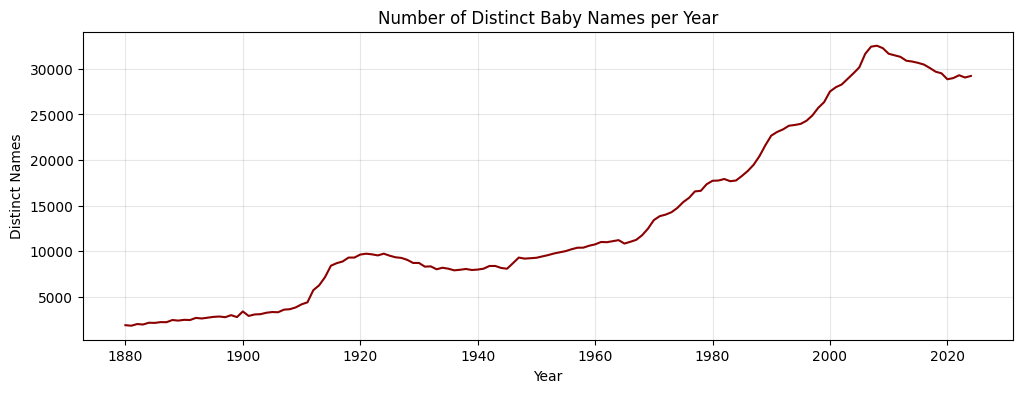

In [25]:
distinct = names.groupby("year")["name"].nunique()

plt.figure(figsize=(12,4))
plt.plot(distinct.index, distinct.values, color="darkred")
plt.title("Number of Distinct Baby Names per Year")
plt.xlabel("Year")
plt.ylabel("Distinct Names")
plt.grid(alpha=0.3)
plt.show()

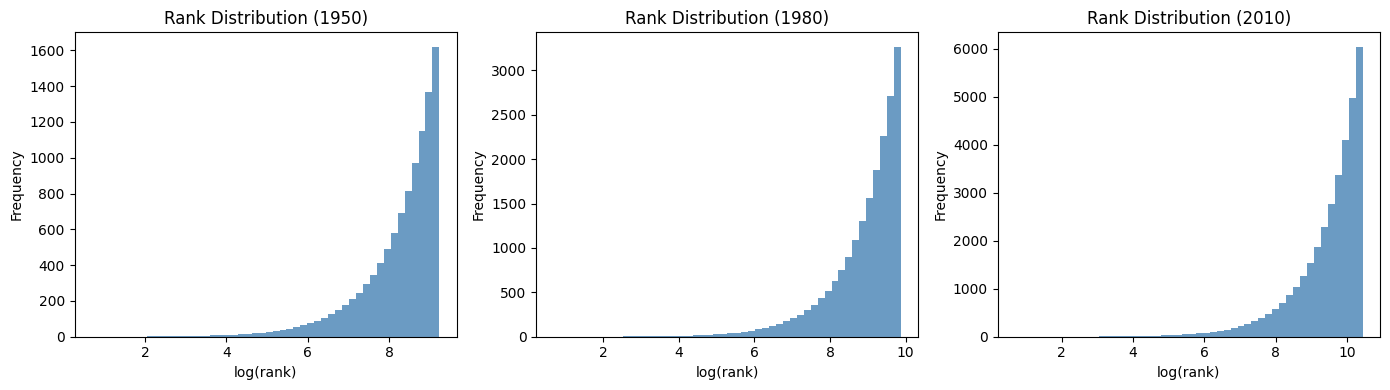

In [36]:
years_to_plot = [1950, 1980, 2010]

plt.figure(figsize=(14,4))
for i, yr in enumerate(years_to_plot):
    subset = names[names["year"] == yr]["rank"]
    plt.subplot(1, 3, i+1)
    plt.hist(np.log1p(subset), bins=50, color="steelblue", alpha=0.8)
    plt.title(f"Rank Distribution ({yr})")
    plt.xlabel("log(rank)")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

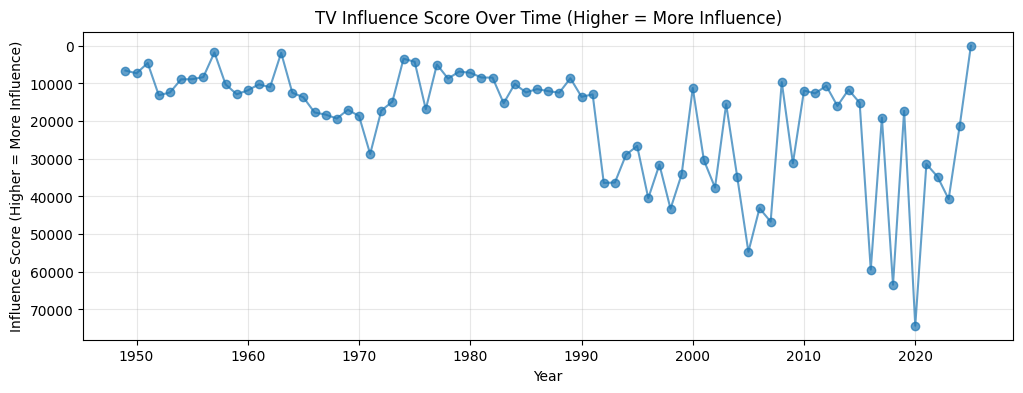

In [33]:
plt.figure(figsize=(12,4))
plt.plot(influence["year"], influence["total_rank"], marker="o", linestyle="-", alpha=0.7)
plt.gca().invert_yaxis()
plt.title("TV Influence Score Over Time (Higher = More Influence)")
plt.xlabel("Year")
plt.ylabel("Influence Score (Higher = More Influence)")
plt.grid(alpha=0.3)
plt.show()